In [52]:
from intuitlib.client import AuthClient
from quickbooks import QuickBooks
from quickbooks.objects.account import Account
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar
from dateutil import parser

In [2]:
def proc_rows(rows, category = "", level=0):
    row_list = []
    for row in rows:
        if "Header" in row:
            header_col = row['Header']['ColData'][0]['value']
            if category == "":
                current_category = header_col
            else:
                current_category = f"{category}:{header_col}"
            row_list.extend(proc_rows(row['Rows']['Row'], category = current_category, level = level+1))
        else:
            col_data = row['ColData']
            if len(col_data)==len(cols):
                cur_row = {cols[i]:col_data[i]['value'] for i in range(len(cols))}
                cur_row.update({"category":category})
                cur_row.update({"category_level":level})
                row_list.append(cur_row)
    return row_list

In [3]:
auth_client = AuthClient(
        client_id='ABVlDV6VbSq3SyfN6ShES7gauQ8LExHxnhuoDVsKaEOe3GmBrT',
        client_secret='zqQX950hO9CICCreDvfAvk3mE7tuJJKrGyyrRxEU',
        access_token=None,
        environment='production',
        redirect_uri='https://developer.intuit.com/v2/OAuth2Playground/RedirectUrl',
    )

In [4]:
client = QuickBooks(
        auth_client=auth_client,
        refresh_token='AB117023062162rDFvIRMU11FsBJCY5GVFQS1niofojKma7HAx',
        company_id='514655250',
    )

In [5]:
df_list = []
year = 2023
for month in range(1,9):
    days = calendar.monthrange(year,month)[1]
    month_name = calendar.month_name[month]
    print(f"Grabbing report details for {month_name}")
    json_resp = client.get_report("ProfitAndLossDetail", {"start_date":f"{year}-{month}-01", "end_date":f"{year}-{month}-{days}"})
    cols = [i["ColTitle"] for i in json_resp['Columns']['Column']]
    report_info = json_resp['Header']
    row_list = proc_rows(json_resp["Rows"]["Row"][0]['Rows']['Row'])
    df_list.append(pd.DataFrame(row_list))

Grabbing report details for January
Grabbing report details for February
Grabbing report details for March
Grabbing report details for April
Grabbing report details for May
Grabbing report details for June
Grabbing report details for July
Grabbing report details for August


In [6]:
qbdf = pd.concat(df_list)
qbdf

In [7]:
qbdf.to_csv("january_to_june.csv")

In [95]:
# data manipulation
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)
qbdf['Account_Type'] = qbdf['category'].apply(lambda x: x.split(':')[0])
qbdf['Date'] = pd.to_datetime(qbdf['Date'])

budget_map = "../resources/qb_to_budget_map.csv"
budgetdf = pd.read_csv(budget_map)
budgetdf['Budget'] = budgetdf['Budget']*12.0
budget_items = budgetdf['QB_Item'].unique()

expenses = qbdf.loc[qbdf['Account_Type']=='Expenses']
income = qbdf.loc[qbdf['Account_Type'] == 'Income']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [96]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum"}).reset_index()
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [97]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

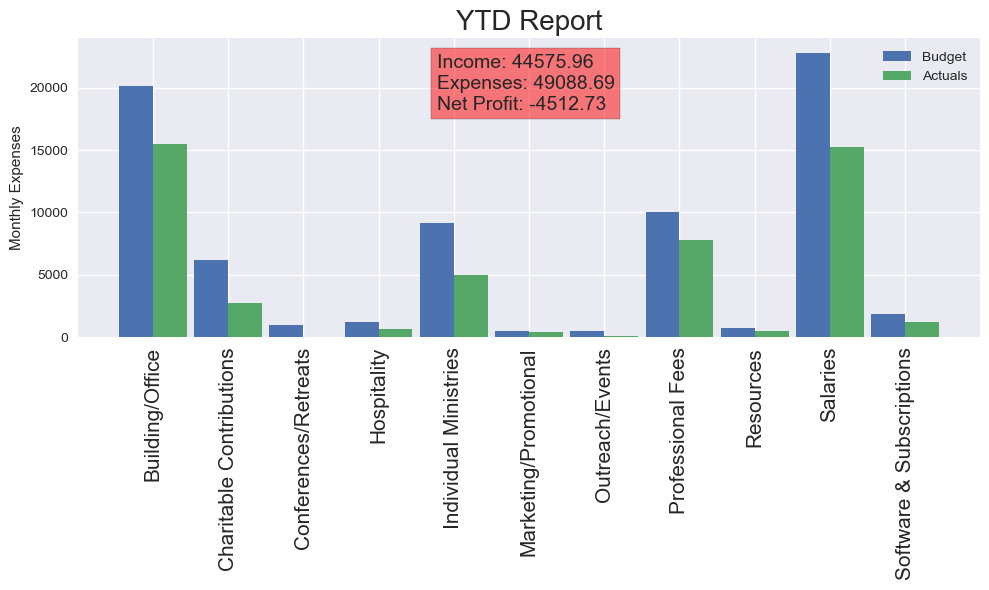

In [98]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title("YTD Report", fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

In [15]:
special_account = income[income['item']=="Worship Contribution"]

In [99]:
special_account[['Date','Amount','Transaction Type']]

,Date,Amount,Transaction Type
13,2023-07-05,5000.00,Deposit
14,2023-07-06,-1297.32,Expense
15,2023-08-01,1297.32,Deposit
16,2023-08-01,-1297.60,Expense
17,2023-08-08,-250.00,Check
18,2023-08-21,-600.00,Check


In [42]:
list(y)[-1]

2852.4

Text(0.5, 1.0, 'Worship Contribution Account Balance')

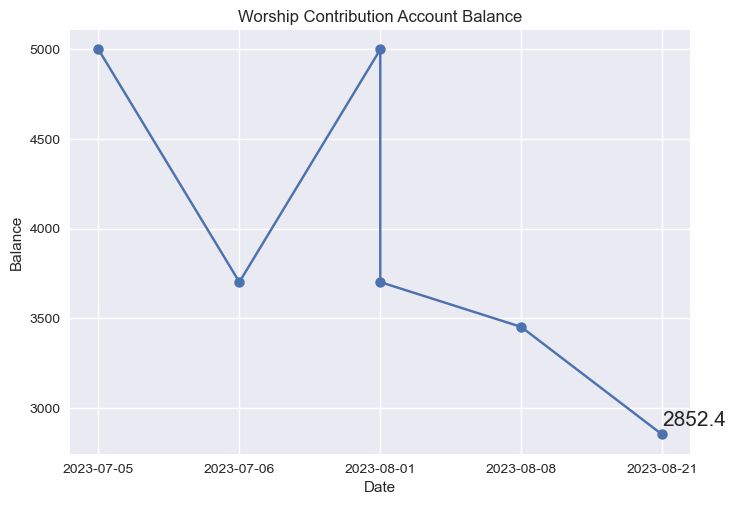

In [100]:
fig, ax = plt.subplots()
x = special_account['Date']
y = special_account['Amount'].cumsum()
ax.plot(x,y, marker='.', markersize=15)
ax.set_ylabel("Balance")
ax.set_xlabel("Date")
ax.text(list(x)[-1],list(y)[-1]+50,f"{list(y)[-1]}",size=15)
ax.set_title("Worship Contribution Account Balance")

In [71]:
all_totals[~all_totals['item'].isin(['Lead Pastor','Associate Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Category','Subcategory','item','Amount']]

,Category,Subcategory,item,Amount
30,Ministry,Individual Ministries,Honorarium/Blessing,1200.00
16,Facilities,Professional Fees,Lawn/Snow,885.00
13,Facilities,Professional Fees,Utilities,367.15
7,Facilities,Building/Office,Repair and Maintenance,180.00
21,Facilities,Software & Subscriptions,Software and Subscriptions,176.16
20,Facilities,Hospitality,Food for Events/Sunday Morning,109.30
5,Facilities,Building/Office,Communications,81.23
32,Ministry,Resources,Right Now Media,59.99
17,Facilities,Professional Fees,Incorporation Fees,50.00
19,Facilities,Hospitality,Kitchen/Cleaning/Paper Supplies,46.48


In [156]:
start_time = parser.parse('2023-01-01')
end_time = parser.parse('2024-01-01')
expense_max_date = expenses['Date'].max()
income_max_date = income['Date'].max()

# trim data set to time period of interest and remove special accounts
period_expenses = expenses.loc[(expenses['Date']>=start_time) & (expenses['Amount']<4000)]
period_income = income.loc[(income['Date']>=start_time) & (income['item']!="Worship Contribution") & (income['item']!='Olive Tree (Tenant Lease)')]

expense_days = (expense_max_date - start_time).days
income_days = (income_max_date - start_time).days


expense_per_day = period_expenses['Amount'].sum() / expense_days
income_per_day = period_income['Amount'].sum() / income_days


remaining_expenses = expense_per_day * (end_time - expense_max_date).days
remaining_income = income_per_day * (end_time - income_max_date).days

projected_expense_total = remaining_expenses + expenses['Amount'].sum()
projected_income_total = remaining_income + income['Amount'].sum()

print(f"Projected Expenses: {projected_expense_total}")
print(f"Projected Income: {projected_income_total}")
print(f"Projected Net Profit: {projected_income_total-projected_expense_total}")

Projected Expenses: 69964.02825726141
Projected Income: 63611.85126050421
Projected Net Profit: -6352.176996757196


In [182]:
income_line.tail(1)

,Amount,Date
14,44575.96,2023-08-27


KeyError: 0

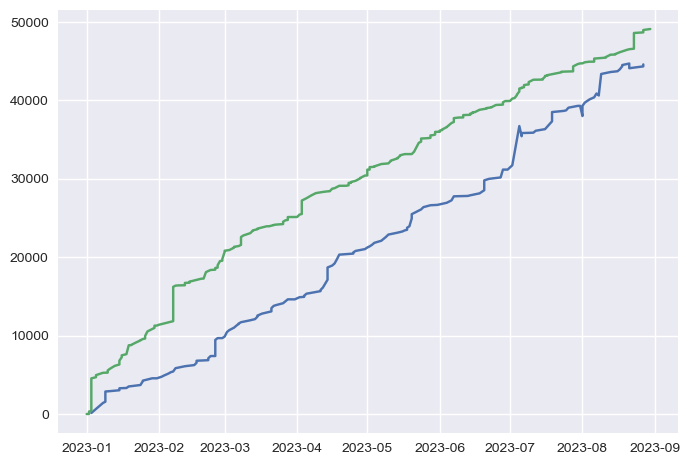

In [173]:
fig, ax = plt.subplots()
expense_line = expenses.sort_values('Date')[['Amount','Date']]
expense_line['Amount'] = expense_line['Amount'].cumsum()
income_line = income.sort_values('Date')[['Amount','Date']]
income_line['Amount'] = income_line['Amount'].cumsum()
ax.plot(income_line['Date'], income_line['Amount'])
ax.plot(expense_line['Date'],expense_line['Amount'])
projected_income_dates = [income_line.tail(1)['Date'][0], parser.parse('2024-01-01')]
projected_income_line = [income_line.tail(1)['Amount'][0], projected_income_total]
ax.plot(income_line['Date'].max())
ax.set_title("Projected Income/Expenses YTD")
plt.show()

In [167]:
expense_line = pd.concat([expense_line,pd.DataFrame({'Amount':remaining_expenses,'Date':parser.parse('2024-01-01')},index=[0])])
income_line = pd.concat([income_line,pd.DataFrame({'Amount':remaining_income,'Date':parser.parse('2024-01-01')},index=[0])])

In [164]:
expense_line.iloc[1]['Date']

Timestamp('2023-01-02 00:00:00')